In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import os
from scipy.integrate import solve_ivp
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
import random
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
#this next line is only needed in iPython notebooks
%matplotlib inline 
import math
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
font = fm.FontProperties(family = 'Gill Sans', fname = '/Library/Fonts/GillSans.ttc', size = 12)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def hide_spines(intx=False,inty=False):
    """Hides the top and rightmost axis spines from view for all active
    figures and their respective axes."""

    # Retrieve a list of all current figures.
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    if (plt.gca().get_legend()):
        plt.setp(plt.gca().get_legend().get_texts(), fontproperties=font) 
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
           # ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: ("10$^{%d}$" % math.log(v,10)) ))
            for label in ax.get_xticklabels() :
                label.set_fontproperties(font)
            for label in ax.get_yticklabels() :
                label.set_fontproperties(font)
            #ax.set_xticklabels(ax.get_xticks(), fontproperties = font)
            ax.set_xlabel(ax.get_xlabel(), fontproperties = font)
            ax.set_ylabel(ax.get_ylabel(), fontproperties = font)
            ax.set_title(ax.get_title(), fontproperties = font)
            if (inty):
                ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
            if (intx):
                ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
def show(nm,a=0,b=0,show=1):
    hide_spines(a,b)
    #ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: ("10$^{%d}$" % math.log(v,10)) ))
    #plt.yticks([1,1e-2,1e-4,1e-6,1e-8,1e-10,1e-12], labels)
    #ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: ("10$^{%d}$" % math.log(v,10)) ))
    if (len(nm)>0):
        plt.savefig(nm,bbox_inches='tight');
    if show:
        plt.show()
    else:
        plt.close()

2.0.0-beta1


The equation for the damped pendulum is $$ \ell {\ddot {\theta }}-g\sin \theta ={\ddot {x}}\cos \theta$$ $$\left(M+m\right){\ddot {x}}-m\ell {\ddot {\theta }}\cos \theta +m\ell {\dot {\theta }}^{2}\sin \theta =F$$
Defining $y(t) = \dot{\theta}(t)$ and $z(t)=\dot{x}(t)$, we get the system
$$ \dot{y}(t) = \frac{g}{\ell}\sin \theta +{\dot{z}}\cos \theta,$$
$$ \theta'(t) = y(t).$$

In [5]:
def run_step(f,state):
    #data is theta-dot, theta, x-dot,x
    fabs = np.min([math.fabs(f),100])
    f = f/(math.fabs(f)+1e-14)*fabs
    #print(f,fabs)
    A11 = lambda t,x: 1.5*((M+m)*g-0.5*m*L*x[0]**2*math.cos(x[1]))/(L*(M+m*(1-0.75*math.cos(x[1])**2)))
    A12 = lambda t,x: -1/5*math.cos(x[1])/(L*(M+m*(1-0.75*math.cos(x[1])**2)))
    A21 = lambda t,x: 1.5*(0.5*m*L*x[0]**2 - 0.75*m*g*math.cos(x[1]))/((M+m*(1-0.75*math.cos(x[1])**2)))
    A22 = lambda t,x: 1.5/((M+m*(1-0.75*math.cos(x[1])**2)))

    RHS = lambda t,x: [1/(L*(M+m*math.sin(x[1])**2))* (-f * math.cos(x[1]) - m*L*x[0]**2*math.cos(x[1])*math.sin(x[1])-
                                                     (M+m)*g*math.sin(x[1])),
                      x[0],
                      1/(M+m*math.sin(x[1])**2)* (f + m*math.sin(x[1])*(L*x[0]**2+g*math.cos(x[1]))),
                      x[2]]

    m = 1.
    M = 1.
    g = 9.81
    L = 1.
    rew = lambda x: 1.0/((np.pi-np.abs(x[1]))**4+1e-4) - 0*5*x[3]**2 
    init_reward = rew(state) #-np.log(np.sum(np.diff(solution.t) * np.abs(solution.y[1,1:])))
    
    solution = solve_ivp(fun=RHS, y0=state, t_span=[0,1.0/32.0], max_step=0.001, method="RK45")
    reward = rew(solution.y[:,-1]) #-np.log(np.sum(np.diff(solution.t) * np.abs(solution.y[1,1:])))
    htg = (np.cos(math.pi-solution.y[1,-1]))
    htg_rew = ((htg+1.0)*10//5)*10*(htg>= -0.5)
    return reward-0*init_reward+htg_rew-0.001*(solution.y[-1,-1])**2, solution.y[:,-1]

In [6]:
ang = math.pi/2+0.1
rew,state = run_step(0,[0,ang,0,0])

print(rew,state,math.cos(math.pi-ang))


20.210927309768344 [-3.06511434e-01  1.66600672e+00 -1.45695017e-02 -2.33374053e-04] 0.0998334166468283


In [7]:
model = tf.keras.Sequential()
ksize = 3
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Dense(6, activation='relu', input_shape=(4,)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 30        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
Total params: 99
Trainable params: 81
Non-trainable params: 18
_________________________________________________________________


In [8]:
def run_case(rand=0,init_val=np.zeros(1),steps=2):
    vals = np.array([-10.,0.,10.])
    states = np.zeros((steps,4))
    rewards = np.zeros(steps)
    moves = np.zeros((steps,3))
    if (init_val.size == 1):
        init_val = np.random.uniform(high=1,low=-1,size=4)
        init_val[1] = np.pi + np.random.uniform(high=0.2,low=-0.2,size=1)
        init_val[1] = np.arctan2(math.sin(init_val[1]),math.cos(init_val[1]))
        if (random.random() < 90.5):
            init_val *= 0
        #init_val[2:] = 0.
    states[0,:] = init_val
    for i in range(steps):
        if (rand > 0) and (random.random() < rand):
            tmp = random.random()
            moves[i] = np.array([(tmp<1.0/3.0)*1,(tmp>=1.0/3.0)*(tmp<2.0/3.0)*1,(tmp>=2.0/3.0)*1])
        elif (rand == -9):
            moves[i] = states[i,1]/math.fabs(states[i,1])*(1-np.sin(states[i,1]))*g*2
        else:
            moves[i] = model.predict(states[i:i+1,:])
        tmp = random.random()
        f = 0.0
        if (tmp < moves[i,0]):
            f = vals[0]
            moves[i,:] = 0
            moves[i,0] = 1
        elif (tmp < moves[i,0] + moves[i,1]):
            f = vals[1]
            moves[i,:] = 0
            moves[i,1] = 1
        else: 
            f = vals[2]
            moves[i,:] = 0
            moves[i,2] = 1
        rewards[i], state = run_step(f,states[i])
        #print(rewards[i])
        state[1] = np.arctan2(math.sin(state[1]),math.cos(state[1]))
        if i<steps-1 :
            states[i+1,:] = state
        if (1-math.cos(state[1]) < -5):
            break
    states = states[0:i,:]
    rewards = np.sum(rewards)*np.ones(i)
    #rewards = rewards[0:i]
    moves = moves[0:i]
    #rewards -= np.mean(rewards)
    #rewards /= np.std(rewards)
    return moves, states, rewards.reshape((-1,1))

In [9]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['MAE'])

In [10]:
train = 0
if (train==1):
    cases = 5
    cases_per_epoch = 50
    st = 200
    rnds = np.logspace(math.log10(1),-2,cases)
    for i in range(cases):
        print("Case",i+1,"of",cases)
        for j in range(cases_per_epoch):
            if (j==0) and (i==0):
                moves,states,rewards = run_case(rand=rnds[i],steps=st)
            else:
                movetmp, st_tmp, rew_tmp = run_case(rand=rnds[i],steps=st)
                moves = np.vstack([moves,movetmp])
                states = np.vstack([states,st_tmp])
                rewards = np.vstack([rewards,rew_tmp])
        print(moves.shape)
        adjusted_rewards = rewards - np.mean(rewards)
        adjusted_rewards /= np.std(rewards) + 1e-10
        model.fit(x=states, y=moves, sample_weight=adjusted_rewards.reshape(-1), 
                  epochs=20, batch_size=st, shuffle=True)



In [11]:
if (train == 1):
    model.save_weights("inverse_pendulum_long_train")
model.load_weights("inverse_pendulum_long_train")

In [12]:
def display_series(state):
    for step in range(10):
        f, state = run_step(model.predict(state.reshape((1,4))),state)
        print(model.predict(state.reshape((1,4))))
        plt.plot(step,state[1],'bo')

-5.983726227466291 2.9583174727666433


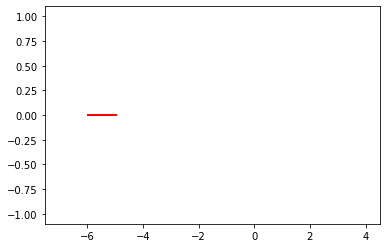

In [14]:
vals = np.array([-10.,0.,10.])
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True)
g = 9.81
import matplotlib.patches as patches
moves,states,rewards = run_case(rand=0,init_val=np.array([0,0,0.000,0]),steps=200)
xmin = np.min(states[:,-1])
xmax = np.max(states[:,-1])
print(xmin,xmax)

line, = ax.plot([], [], 'o-', lw=2)
linem, = ax.plot([], [], 'r-', lw=2)

def init():
    #ax.axis("equal")
    #ax.set_ylim(-0.5,1)
    #ax.set(xlim=(0, 100), ylim=(-0.5, 2))
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data([states[frame,-1],np.sin(math.pi-states[frame,1])+states[frame,-1]], [0,np.cos(math.pi-states[frame,1])])
    linem.set_data([states[frame,-1],states[frame,-1]+vals[np.argmax(moves[frame])]/10],[0,0])
    ax.plot([xmin-1,xmax+1],[0,0],alpha=0)
    ax.plot([xmin-1,xmax+1],[1,1],alpha=0)
    ax.plot([xmin-1,xmax+1],[-1,-1],alpha=0)
    ax.relim()
    ax.autoscale_view()
    return line,

ani = FuncAnimation(fig, update, frames=range(moves.shape[0]),
                    init_func=init, blit=False)

from IPython.display import HTML
HTML(ani.to_html5_video())

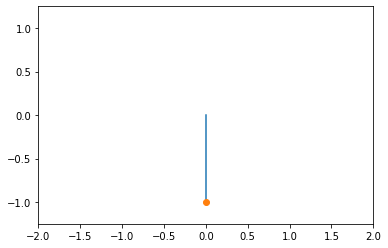

What force? (q for done)q


In [66]:
vals = np.array([-10.,0.,10.])
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True)
g = 9.81
import matplotlib.patches as patches
state = 0*np.array([0,-math.pi-0.1,0,0])
done = 0
while not(done):
    plt.plot([state[-1],np.sin(math.pi-state[1])+state[-1]], [0,np.cos(math.pi-state[1])])
    plt.plot([np.sin(math.pi-state[1])+state[-1]], [np.cos(math.pi-state[1])],'o')
    plt.plot([np.sin(math.pi-state[1])+state[-1],np.sin(math.pi-state[1])+state[-1]+state[0]], 
             [np.cos(math.pi-state[1]),np.cos(math.pi-state[1])],'-')
    plt.axis([-2,2,-1.25,1.25])
    plt.show()
    val = input("What force? (q for done)")
    if (val=="q"):
        done = 1
    else:
        reward,state = run_step(float(val),state)


In [73]:
vals = np.array([-10.,0.,10.])
#fig = plt.figure()
np.random.seed(10)
random.seed(24) #22 23 24
#ax = fig.add_subplot(111, autoscale_on=True)
g = 9.81
import matplotlib.patches as patches
moves,states,rewards = run_case(rand=0,init_val=np.array([0,0,0.000,0]),steps=200)
xmin = np.min(states[:,-1])
xmax = np.max(states[:,-1])
print(xmin,xmax, np.sum(rewards))

-1.328547844779617 9.052389396853375 1208251.6216507168


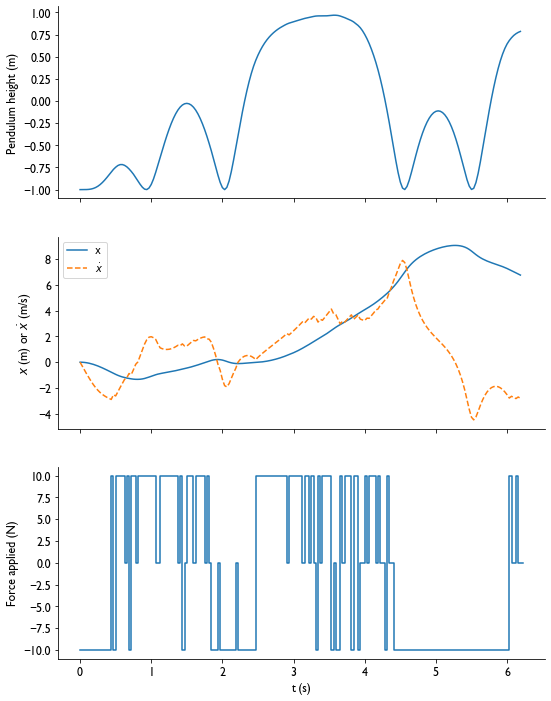

In [244]:
fig, ax = plt.subplots(3, 1, figsize=(12*.727,12), sharex=True, sharey=False)
ax[0].plot(1/32*np.arange(states.shape[0]),np.cos(math.pi-states[:,1]))
#ax[0].set_xlabel("t (s)")
ax[0].set_ylabel("Pendulum height (m)")
ax[1].plot(1/32*np.arange(states.shape[0]),states[:,-1],label="x")
ax[1].plot(1/32*np.arange(states.shape[0]),states[:,2],"--",label="$\\dot{x}$")
ax[1].legend(loc="best")
#ax[1].set_xlabel("t (s)")
ax[1].set_ylabel("$x$ (m) or $\\dot{x}$ (m/s)")
tmp = np.zeros((2*states.shape[0],2))
tmp[0:tmp.shape[0]:2,0] = 1/32*np.arange(states.shape[0])
tmp[0:tmp.shape[0]:2,1] = vals[np.argmax(moves,axis=1)]
tmp[1:tmp.shape[0]:2,0] = 1/32*np.arange(states.shape[0]) + 1/32-1e-6
tmp[1:tmp.shape[0]:2,1] = vals[np.argmax(moves,axis=1)]
ax[2].plot(tmp[:,0],tmp[:,1])
ax[2].set_xlabel("t (s)")
ax[2].set_ylabel("Force applied (N)")
for i in range(3):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    #ax[i].set_aspect("equal")
    
    for label in ax[i].get_xticklabels() :
        label.set_fontproperties(font)
    for label in ax[i].get_yticklabels() :
        label.set_fontproperties(font)
    #ax.set_xticklabels(ax.get_xticks(), fontproperties = font)
    ax[i].set_xlabel(ax[i].get_xlabel(), fontproperties = font)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontproperties = font)
    ax[i].set_title(ax[i].get_title(), fontproperties = font)
plt.savefig("cart_plan.pdf")

114
13
29
45
61
77
93
109
125
141
157
173
189


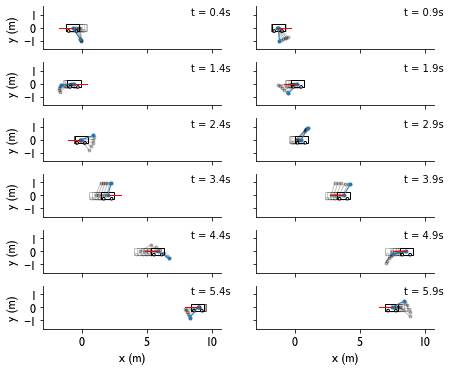

In [241]:

print(np.argmax(np.cos(math.pi-states[:,1])))
fig, ax = plt.subplots(6, 2, figsize=(7,6), sharex=True, sharey=True)
from matplotlib.patches import Ellipse, Polygon, Rectangle,Circle
theta = 0
xl = 1 #(xmax-xmin)*0.75
for f in range(12):
    i = (f)//2
    j = (f) % 2
    frame = rewards.shape[0]//12*f+13
    print(frame)
    for af in range(0,10,2):
        center = np.array([states[frame-af-1,-1],0])/xl
        ax[i,j].add_patch(Rectangle(center-[0.5,0.25],1,0.5, facecolor="white", edgecolor="black", alpha=0.25))
        ax[i,j].add_patch(Circle(center-[0.3,0.25],0.1, facecolor="white", edgecolor="black", alpha=0.25))
        ax[i,j].add_patch(Circle(center+[0.3,-0.25],0.1, facecolor="white", edgecolor="black", alpha=0.25))
        ax[i,j].plot(np.array([states[frame-af-1,-1],np.sin(math.pi-states[frame-af-1,1])+states[frame-af-1,-1]])/xl, 
                 [0,np.cos(math.pi-states[frame-af-1,1])],
                 'ko-', lw=1, markersize=3, alpha=0.25)
    center = np.array([states[frame,-1],0])/xl
    ax[i,j].add_patch(Rectangle(center-[0.5,0.25],1,0.5, facecolor="white", edgecolor="black"))
    ax[i,j].add_patch(Circle(center-[0.3,0.25],0.1, facecolor="white", edgecolor="black"))
    ax[i,j].add_patch(Circle(center+[0.3,-0.25],0.1, facecolor="white", edgecolor="black"))
    ax[i,j].plot(np.array([states[frame,-1],np.sin(math.pi-states[frame,1])+states[frame,-1]])/xl, 
             [0,np.cos(math.pi-states[frame,1])],
             'o-', lw=1, markersize=3)
    ax[i,j].text(xmax+(xmin)/2,1,"t = %2.1fs" % (frame*1.0/32.0))
    ax[i,j].plot(np.array([states[frame,-1],states[frame,-1]+vals[np.argmax(moves[frame])]/10])/xl,[0,0], 'r-', lw=1)
    
    ax[i,j].plot(np.array([xmin-1,xmax+1])/xl,[0,0],alpha=0)
    ax[i,j].plot(np.array([xmin-1,xmax+1])/xl,[1.5,1.5],alpha=0)
    ax[i,j].plot(np.array([xmin-1,xmax+1])/xl,[-1.5,-1.5],alpha=0)
    ax[i,j].spines['right'].set_color('none')
    ax[i,j].spines['top'].set_color('none')
    ax[i,j].set_aspect("equal")
    if (i==5):
        ax[i,j].set_xlabel("x (m)")
    if (j==0):
        ax[i,j].set_ylabel("y (m)")
    for label in ax[i,j].get_xticklabels() :
        label.set_fontproperties(font)
    for label in ax[i,j].get_yticklabels() :
        label.set_fontproperties(font)
    #ax.set_xticklabels(ax.get_xticks(), fontproperties = font)
    ax[i,j].set_xlabel(ax[i,j].get_xlabel(), fontproperties = font)
    ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontproperties = font)
    ax[i,j].set_title(ax[i,j].get_title(), fontproperties = font)
#plt.show()#"cart_move.pdf")
plt.savefig("cart_move.pdf",bbox_inches='tight')

In [181]:
"%2.2f" % (frame*1.0/32.0)

'5.81'

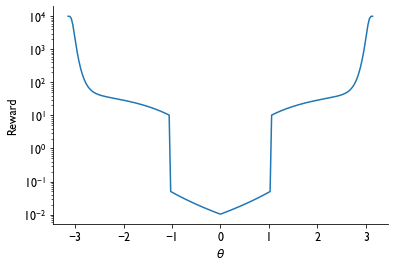

In [20]:
theta = np.linspace(-np.pi,np.pi,200)
#plt.semilogy(np.cos(math.pi-theta),1/(np.abs(np.pi-np.abs((theta))) + 1e-4))
plt.semilogy(theta,(np.cos(math.pi-theta)>-0.5)*10*(10//5*(np.cos(math.pi-theta)+1))+
             1/(np.abs(np.pi-np.abs((theta)))**4 + 1e-4))
plt.xlabel("$\\theta$")
plt.ylabel("Reward")
show("../Chapter10/reward_pendulum.pdf")

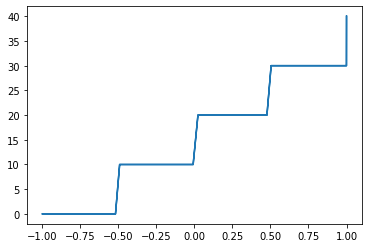

In [330]:
plt.plot(np.cos(math.pi-theta),10*((np.cos(math.pi-theta)+1.0)*10//5)*1.0*((np.cos(math.pi-theta)+0.5>=0)))

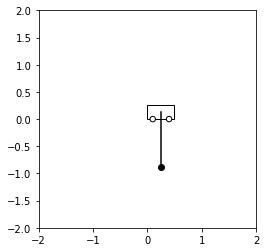

In [49]:

from matplotlib.patches import Ellipse, Polygon, Rectangle,Circle
fig = plt.figure()
ax = fig.gca()
theta = 0
center = np.array([0.25,0.125])
ax.add_patch(Rectangle(center-[0.25,0.125],0.5,0.25, facecolor="white", edgecolor="black"))
ax.add_patch(Circle(center-[0.15,0.125],0.05, facecolor="white", edgecolor="black"))
ax.add_patch(Circle(center+[0.15,-0.125],0.05, facecolor="white", edgecolor="black"))
plt.plot([center[0],center[0]+np.sin(math.pi-theta)],[center[1],center[1]+np.cos(math.pi-theta)],"k")
plt.plot([center[0]+np.sin(math.pi-theta)],[center[1]+np.cos(math.pi-theta)],"ko")
plt.axis([-2,2,-2,2])
ax.set_aspect("equal")

In [247]:
print(np.logspace(math.log10(1),-2,5))

[1.         0.31622777 0.1        0.03162278 0.01      ]
